# Kalman Filter, introduction
Kalman filter is an algorithm that uses a series of measurements observed over time, including statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe. The basic idea is to use each consecutive measurements to improve our previous predictions by the model built on previous measurements. With enough measurements, the model can be improved and truly described the underlying physics/mechanism behind a certain system. 

We will motivate the algorithm through a simple filter, and slowly build up the algorithm from the simple filter. Finally, we will build up the Kalman filter for Gillespie algorithm to estimate the rate given the kinetic scheme and initial population. 


# Filter - a recursive average algorithm
No information is bad information, it is a matter of 
the good out from the noise.

In any measurement, there will always be uncertainty due to various reasons, either from the tool itself, or external factors. This is known as the random error, and it can be easily avoided by repeating the measurements. We will then calculate the mean $\bar{\boldsymbol{z}_t}$ from the data $M \in \{\boldsymbol{z}_{1}, \boldsymbol{z}_{2}, ..., \boldsymbol{z}_t\}$ collected from $t$ measurements. 
 \begin{equation}\bar{\boldsymbol{z}}_t = \frac{1}{t}\sum_{i=1}^t \boldsymbol{z}_i \end{equation}
 
Since the tools are admitted to be inaccurate, the calculated mean may not be the true value $\boldsymbol{x}$, but this is the most reasonable guess we could make about the true value based on $t$ measurements, i.e. $\boldsymbol{x}_{t,t} = \bar{\boldsymbol{z}_t}$, where $\boldsymbol{x}_{t,t}$ is our prediction of the $\vec{x}$ at $t$ after performing $t$ measurements . We can try to reduce the random errors through more measurements, and calculate the mean. The measured value will approach to the true value after a certain number of measurement $\boldsymbol{x}_{t,t}\rightarrow \boldsymbol{x}$.  Till when should we stop the measurement and say that we are certain of the value - when the mean converges and any additional measurements do not change the mean drastically. This requires us to write the mean as a recursive equation. A recursive equation also has an advantage of saving the computational resources as the number of data point increases, since we do not need to keep all the data inside the memory. :
\begin{align}
\vec{\boldsymbol{x}}_{t,t} &= \frac{1}{t}\Big(\sum_{i=1}^{t-1}\boldsymbol{z}_i + \boldsymbol{z}_t\Big) \\
&= \frac{1}{t}\Big(\frac{t-1}{t-1} \sum_{i=1}^{t-1} \boldsymbol{z}_i\Big) + \frac{1}{t}\boldsymbol{z}_t\\
&= \frac{1}{t}(t-1) \boldsymbol{x}_{t-1, t-1} + \frac{1}{t}\boldsymbol{z}_t \\
&= \boldsymbol{x}_{t-1,t-1} + \frac{1}{t}(\boldsymbol{z}_t - \boldsymbol{x}_{{t-1, t-1}}) 
\end{align}

$\boldsymbol{x}_{t-1, t-1}$ is our prediction of the true value at $t-1$ based on $t-1$ measurements. Since the process we are considering is static, the prediction about the future value $t$ based on the $t-1$ measurements is equal to the prediction of the true value at $t-1$ based on $t-1$ measurements:
\begin{equation}
\boldsymbol{x}_{t, t-1} = \boldsymbol{x}_{t-1,t-1}
\end{equation}
The above formulation gives the following equation:

\begin{equation}
    \boldsymbol{x}_{t,t} = \boldsymbol{x}_{t,t-1} + \frac{1}{t}(\boldsymbol{z}_t - \boldsymbol{x}_{{t, t-1}}) 
\end{equation}


$\frac{1}{t}$ carries a special meaning, which we shall call the <span style='color: red;'>Kalman gain</span> to motivate our future discussion on Kalman filter. In most filters, this is a free parameter that can be tuned for different purposes.The two terms in the brackets are also meaningful, one represents the mean obtained from $t$ measurements, the other represents the prediction made from the $t-1$ measurements. The difference between them is the amount of "new information" obtained from the latest measurement, which is called the <span style='color: red;'>innovation</span>.  We have derived the <span style='color: red;'> state update equation</span>. 

Consider the following example, where the population of a certain chemical species is measured for a few times. The state $x$ is the chemical species's population. We shall use the recursive mean algorithm to compute the mean population.

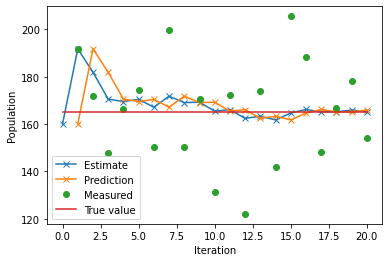

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gen_data(x0, v0, count, noise = 0, accel=0.):
    #generate data given the initial state, velocity, acceleration and noise 
    zs = []
    for i in range(count):
        zs.append(x0 + accel * (i**2) / 2 + v0*i  + noise*np.random.randn())
        v0 += accel
    return zs

measured_population = gen_data(160, 1, 20, 20, 0)
time = np.linspace(0, len(measured_population), endpoint = True, num=len(measured_population)+1)

def recursive_mean(estimated_population, measured_population, do_print=False):     
    # storage for the filtered results
    estimates, predictions = [estimated_population], []
    
    for index, z in enumerate(measured_population): 
        # predict new position
        predicted_population = estimated_population
        #Kalman filter 
        K = 1/(index+1)
        
        # update filter 
        innovation = (z - predicted_population)
        estimated_population= predicted_population + K * innovation
        
        estimates.append(estimated_population)
        predictions.append(predicted_population)
    
    ####debug
    #print(estimates)
    #print(predictions)
    #print(time)
    #print('True population:{}'.format(np.mean(measured_population)))
    #
    
    if do_print:
        fig_test1, ax_test1 = plt.subplots()
        ax_test1.plot(time, estimates,'-x', label = 'Estimate')
        ax_test1.plot(time[1:], predictions,'-x', label = 'Prediction')
        ax_test1.plot(time[1:], measured_population, 'o', label = 'Measured')
        ax_test1.plot(time,np.ones(len(measured_population)+1)*np.mean(measured_population), label = 'True value')
        plt.legend()
        plt.xlabel('Iteration')
        plt.ylabel('Population')
    return estimates, predictions

initial_estimate = 160.
estimates, predictions = recursive_mean(estimated_population=initial_estimate, 
                                                  measured_population=measured_population, do_print=True)     

The measured mean approaches the true value with each iteration. But if you stare at the measured data a bit longer, you will realize there is an upward trend. There are two possibilities here - a. the measurement we got is extremely imprecise, or b. the population increases with time. If (a) is true, the only solution is to either perform more measurements or change the measuring tool. But lets entertain the possibility of (b) - then, how do we predict the rate? 

# State prediction with evolving system

Most systems of interest evolves with time, therefore it is more useful to construct an update equation that takes the underlying dynamics into account. Consider the simplest example where the system evolves at constant velocity. For a chemical system, this is equivalent of a zeroth order reaction system. For now, we denote the change in the state as velocity, $\frac{d\boldsymbol{x}}{dt} = \boldsymbol{\dot{x}}$. Note that the velocity here is not the chemical rate, this is the velocity that describes the change in the state. Its meaning depends on how we define the state, and can be completely mathematical. Our simple 1D population example here cannot give a chemical rate prediction(yet), we will talk more about the model construction later. Remember that the equation of motion for a system in constant velocity can be written as 

\begin{align}
\boldsymbol{x}_{t} &= \boldsymbol{x}_{t-1} + \boldsymbol{\dot{x}}_{t-1}\Delta t \\
\boldsymbol{\dot{x}}_{t} &= \boldsymbol{\dot{x}}_{t-1}
\end{align}

This is known as the <span style='color: red;'>state extrapolation equation</span> (also called a Transition Equation or a Prediction Equation). We will compare the prediction obtained with the mean obtained from the measurement. The update rule for the velocity mean is completely the same as the state update equation derived above, i.e. :
\begin{align}
    \boldsymbol{\dot{x}}_{t,t} &= \boldsymbol{\dot{x}}_{t,t-1} + \beta(\frac{\boldsymbol{z}_t - \boldsymbol{x}_{{t, t-1}}}{\Delta t})  \\
    \boldsymbol{x}_{t,t} &= \boldsymbol{x}_{t,t-1} + \alpha(\boldsymbol{z}_t - \boldsymbol{x}_{{t, t-1}}) 
\end{align}

Notice that I have denoted the gain here as $\alpha$ and $\beta$, both of which are constants. These two values are the filter values: they are determined based on the accuracy of our measurement. If the measurements are very precise, we can assign high value to these values.   

Estimated Population array [160.0, 176.3722050324413, 177.7367127598542, 165.27619866823767, 164.68984951934476, 168.77862020393323, 160.00763760185265, 178.25738590847033, 166.93834817380787, 168.08678320516913, 149.62934669800705, 157.2048237056999, 138.87886208162186, 152.21612416999182, 147.23888198050207, 175.4983315097238, 187.0674793826961, 173.1029995264896, 170.4036218975034, 174.05365902031988, 164.60362153404301]
Estimated velocity array [1, 7.148882012976521, 4.835132298751086, -2.0831262573959695, -1.484415413994748, 0.7448590254385405, -3.0614776255690974, 5.463012747305612, -1.249807445481622, -0.290510454744475, -7.557280875711524, -1.5041777223497776, -8.232891283041088, 0.3951700655233328, -1.7537948364818914, 10.251502909799555, 10.778560895068633, 0.8813445945585805, -0.5509442948593326, 1.1294482722109953, -3.10234603118415]
[161.0, 183.5210870454178, 182.5718450586053, 163.1930724108417, 163.20543410535, 169.52347922937176, 156.94615997628355, 183.72039865577594, 

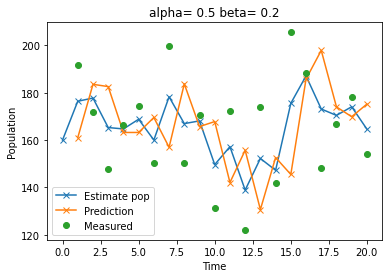

In [2]:
def state_extrapolate(estimated_velocity, estimated_population, delta_t):
    predicted_population = estimated_population + estimated_velocity*delta_t 
    predicted_velocity = estimated_velocity
    return predicted_population, predicted_velocity

def state_update(alpha, beta, current_measurement, predicted_population, predicted_velocity, delta_t):
    innovation = current_measurement - predicted_population
    estimated_velocity = predicted_velocity + beta* innovation *(1/delta_t)
    estimated_population = predicted_population + alpha* innovation
    return estimated_population, estimated_velocity
    
def alpha_beta_filter(alpha, beta, estimated_population, estimated_velocity, measured_population, delta_t, do_print=False):     
    # storage for the filtered results
    estimates_p,estimates_v, predictions = [estimated_population], [estimated_velocity], []
    
    for index, z in enumerate(measured_population): 
        # predict new position
        predicted_population, predicted_velocity = state_extrapolate(estimated_velocity, estimated_population, delta_t)

        # update filter 
        estimated_population, estimated_velocity= state_update(alpha, beta, z, predicted_population, predicted_velocity, delta_t)
        
        ######debug 
        #print(K)
        
        estimates_p.append(estimated_population)
        estimates_v.append(estimated_velocity)
        predictions.append(predicted_population)
    
    ####debug
    print('Estimated Population array {}'.format(estimates_p))
    print('Estimated velocity array {}'.format(estimates_v))
    print(predictions)
    #print(time)
    print('The final predicted rate is {}'.format(round(predicted_velocity,2)))
    #
    
    if do_print:
        time = np.linspace(0, len(measured_population), endpoint = True, num=len(measured_population)+1)
        fig_ab, ax_ab = plt.subplots()
        ax_ab.plot(time, estimates_p,'-x', label = 'Estimate pop')
        #ax_test1.plot(time, estimates_v,'-o', label = 'Estimate vel')
        ax_ab.plot(time[1:], predictions,'-x', label = 'Prediction')
        ax_ab.plot(time[1:], measured_population, 'o', label = 'Measured')
        #actual = np.linspace(160, 172, endpoint= True, num = len(measured_population))
        #ax_ab.plot(time[1:], actual, '-k', label = 'Actual')
        #ax_test1.plot(time,np.ones(len(measured_population)+1)*np.mean(measured_population), label = 'True value')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title('alpha= {} beta= {}'.format(alpha,beta))
    return estimates_p, estimates_v, predictions

init_estimate_population = 160.
init_estimate_rate = 1
alpha = 0.5
beta = 0.2
delta_t = 1

estimates_p,estimates_v, predictions = alpha_beta_filter(alpha, beta, init_estimate_population, init_estimate_rate, 
                                                         measured_population, delta_t, do_print=True)


# State prediction with accelerating system - $\alpha-\beta-\gamma$ Filter

Consider the following system where the velocity is not constant. 


Estimated Population array [10, 11.379477913025278, 10.549741242143321, 18.53415621729969, 39.9298636071336, 78.23721765913575, 134.79386936414664, 215.81527943055545, 322.3713741625403, 455.47587113816417, 617.8088457315216, 808.2920054929233, 1023.3316026400905, 1272.8373622744343, 1550.9772523838692, 1860.9779051501978, 2206.0705851618545, 2581.842099615664, 2989.6248760473804, 3428.360325969285, 3896.6278550168636]
Estimated velocity array [0, 0.13794779130252785, 0.041179345084079416, 0.8355029080913082, 2.891523356265568, 6.433106425839227, 11.445460953756395, 18.403055865021635, 27.218359751717955, 37.806973474108545, 50.25957358603344, 64.28193220357026, 79.35769869792996, 96.37250479157134, 114.5492433233577, 134.09438426765482, 155.19421384205504, 177.2519439032305, 200.3050271560791, 224.14806943266163, 248.5600153941533]
[10, 11.517425704327806, 10.590920587227401, 19.369659125390996, 42.82138696339916, 84.67032408497498, 146.23933031790304, 234.21833529557708, 349.58973391

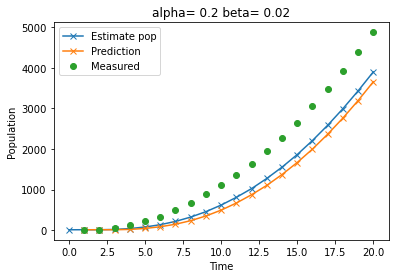

In [3]:
zs = gen_data(x0=10., v0=0., count=20, noise= 10, accel=9.)
estimates_p,estimates_v, predictions = alpha_beta_filter(alpha=0.2, beta=0.02, estimated_population=10, 
                                                         estimated_velocity =0, measured_population = zs, delta_t=1, do_print=True)

The prediction is lagging behind the true population. This is a well known error known as the lag error, and understandably so since the $\alpha-\beta$ filter assumes constant velocity, therefore it is natural that the algorithm produces poor population prediction as time evolves. We will not dive too deep into the detail, but one way to solve this is to introduce the acceleration term in the filter. Consider the case of constant acceleration, we tweak the state extrapolation rule:
\begin{align}
\boldsymbol{x}_{t} &= \boldsymbol{x}_{t-1} + \boldsymbol{\dot{x}}_{t-1}\Delta t + \frac{1}{2}\boldsymbol{\ddot{x}_{t-1}}\Delta t^2\\
\boldsymbol{\dot{x}}_{t} &= \boldsymbol{\dot{x}}_{t-1} + \boldsymbol{\ddot{x}}_{t-1}\Delta t \\
\boldsymbol{\ddot{x}}_{t} &= \boldsymbol{\ddot{x}}_{t-1}
\end{align}

and the update rule:
\begin{align}
    \boldsymbol{\ddot{x}}_{t,t} &= \boldsymbol{\ddot{x}}_{t,t-1} + 2\gamma(\frac{\boldsymbol{z}_t - \boldsymbol{x}_{{t, t-1}}}{\Delta t^2})  \\
    \boldsymbol{\dot{x}}_{t,t} &= \boldsymbol{\dot{x}}_{t,t-1} + \beta(\frac{\boldsymbol{z}_t - \boldsymbol{x}_{{t, t-1}}}{\Delta t})  \\
    \boldsymbol{x}_{t,t} &= \boldsymbol{x}_{t,t-1} + \alpha(\boldsymbol{z}_t - \boldsymbol{x}_{{t, t-1}}) 
\end{align}

This filter is known as the $\alpha-\beta-\gamma$ filter

Estimated Population array [10, 12.758955826050556, 11.154661600807653, 26.913728911417877, 69.7797874028912, 145.9917907015228, 255.6736282238764, 406.9122569179973, 596.6013878862576, 820.3531321953884, 1076.8769753061936, 1358.0369145487841, 1651.5236235088778, 1973.5467849315073, 2311.7141374363273, 2672.101109112698, 3062.3605044384453, 3475.497740767816, 3915.463619835956, 4381.6937947143015, 4872.63060395944]
Estimated velocity array [0, 1.3794779130252786, 0.16348742649624426, 7.938795737331472, 26.939503471592033, 56.60555601771563, 93.1007493853424, 137.4343698055032, 184.64021908353115, 230.4999265092561, 273.72698214551576, 310.2609496896931, 335.4346140302409, 360.6122483588226, 379.93201580344777, 398.4572195261353, 420.70152879945977, 442.44282151789514, 465.9713599994883, 490.62008290041206, 515.3236430221566]
Estimated acceleration array [0, 0.2758955826050557, -0.022481631221762277, 1.5370763571896355, 5.02980263260382, 9.957052615307774, 15.26468076577157, 21.0784686

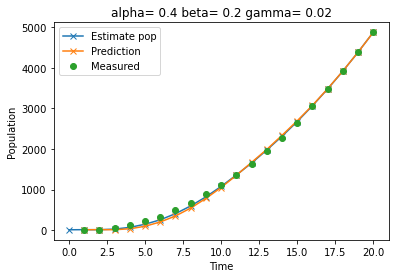

In [4]:
def state_extrapolate_2(estimated_acce, estimated_velocity, estimated_population, delta_t):
    predicted_population = estimated_population + estimated_velocity*delta_t 
    predicted_velocity = estimated_velocity + estimated_acce*delta_t
    predicted_acce = estimated_acce
    return predicted_population, predicted_velocity, predicted_acce

def state_update_2(alpha, beta, gamma, current_measurement, predicted_population, predicted_velocity, predicted_acce, delta_t):
    innovation = current_measurement - predicted_population
    estimated_acce = predicted_acce + 2*gamma*innovation*(1/delta_t)
    estimated_velocity = predicted_velocity + beta* innovation *(1/delta_t)
    estimated_population = predicted_population + alpha* innovation
    return estimated_population, estimated_velocity, estimated_acce
    
def abg_filter(alpha, beta, gamma, estimated_population, estimated_velocity, estimated_acce, 
                      measured_population, delta_t, do_print=False):     
    # storage for the filtered results
    estimates_p,estimates_v, estimates_a, predictions = [estimated_population], [estimated_velocity], [estimated_acce], []
    
    for index, z in enumerate(measured_population): 
        # predict new position
        predicted_population, predicted_velocity, predicted_acce = state_extrapolate_2(estimated_acce,
                                                                                   estimated_velocity, 
                                                                                   estimated_population, 
                                                                                   delta_t)

        # update filter 
        estimated_population, estimated_velocity, estimated_acce= state_update_2(alpha, 
                                                                             beta, 
                                                                             gamma,
                                                                             z, 
                                                                             predicted_population, 
                                                                             predicted_velocity, 
                                                                             predicted_acce,
                                                                             delta_t)
        
        ######debug 
        #print(K)
        
        estimates_p.append(estimated_population)
        estimates_v.append(estimated_velocity)
        estimates_a.append(estimated_acce)
        predictions.append(predicted_population)
    
    ####debug
    print('Estimated Population array {}'.format(estimates_p))
    print('Estimated velocity array {}'.format(estimates_v))
    print('Estimated acceleration array {}'.format(estimates_a))
    print(predictions)
    #print(time)
    print('The final predicted rate is {}'.format(round(predicted_velocity,2)))
    print('The final predicted rate is {}'.format(round(predicted_acce,2)))
    #
    
    if do_print:
        time = np.linspace(0, len(measured_population), endpoint = True, num=len(measured_population)+1)
        fig_abg, ax_abg = plt.subplots()
        ax_abg.plot(time, estimates_p,'-x', label = 'Estimate pop')
        #ax_test1.plot(time, estimates_v,'-o', label = 'Estimate vel')
        ax_abg.plot(time[1:], predictions,'-x', label = 'Prediction')
        ax_abg.plot(time[1:], measured_population, 'o', label = 'Measured')
        #ax_abg.plot(time[1:], actual, '-k', label = 'Actual')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title('alpha= {} beta= {} gamma= {}'.format(alpha,beta, gamma))
    return estimates_p, estimates_v, estimates_a, predictions

estimates_p,estimates_v, estimates_a, predictions = abg_filter(alpha=0.4, 
                                                                      beta=0.2, 
                                                                      gamma=0.02,
                                                                      estimated_population=10,
                                                                      estimated_velocity =0, 
                                                                      estimated_acce =0,
                                                                      measured_population = zs, 
                                                                      delta_t=1, 
                                                                      do_print=True)

Notice that in all 3 filters we introduced, the algorithm always starts with stating our initial belief about the system's evolution and its initial state, perform prediction about the next state, compare the prediction with the measurement, update the state and our beliefs about the true state, and the cycle repeats. In fact, all filters can be summarized using the following algorithm:

Initialization

1. Initialize the state of the filter
2. Initialize our belief in the state

Predict

1. Use system behavior to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction

Update

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. New estimate is somewhere on the residual line

The difference between filters lie in how each adjust the belief. This adjustment is done by the constant we introduced earlier - the gain(or Kalman gain). The two gains we used are the recursive equal weight gain, and a constant gain(alpha, beta and gamma). These gains, however, are not optimal. The most optimal gain is the Kalman gain, and we will try to discuss why that is the case in the next section, and how to construct the Kalman gain. 

# 1D Kalman filter

Lets go back to the derivation of our state update rule. Recall that we arrived at the following equation, which can be generalized as follow:
\begin{align}
\boldsymbol{x}_{t,t} &= \frac{1}{t}\boldsymbol{z}_t + \frac{1}{t}(t-1) \boldsymbol{x}_{t, t-1} \\
                    &= w_1 \boldsymbol{z}_t + w_2\boldsymbol{x}_{t,t-1}\\
                    &= w_1 \boldsymbol{z}_t + (1-w_1)\boldsymbol{x}_{t,t-1}
\end{align}

where $w_1 + w_2 = 1$. This equation tells us that the current estimate is a weighted mean of the measurement and the prior state estimate. What is the uncertainty of the measurement and the prior state estimate? Here, Kalman makes a simple assumption - the errors from both can be described by a Gaussian process. Which means, the uncertainty is described by the variance of two Gaussian distributions $r_t = \sigma^2_r$ and $p_{t,t-1}=\sigma^2_{t,t-1}$, where $r_t$ is the variance of the measurement at time t, and $p_{t,t-1}$ is the variance of our prior estimate. Then, the uncertainty of our current estimate $\boldsymbol{x}_{t,t}$ is as followed:
\begin{equation}
 p_{t,t} = w_1^2 r_t + (1-w_1)^2p_{t,t-1}
\end{equation}

This is also known as the <span style='color: red;'> variance update equation </span>. Since we are looking for the optimum estimate, we want to the best weight $w_1$ that minimize the uncertainty of our estimate $p_{t,t}$.
\begin{align}
0 &= \frac{dp_{t,t}}{dw_1} = 2w_1 r_t + 2w_1 p_{t,t-1} - 2p_{t,t-1} \\
 K_t = w_1 &= \frac{p_{t,t-1}}{p_{t,t-1} + r_t} 
\end{align}

We have derived the <span style='color: red;'>Kalman gain equation </span>, an optimal recursive gain equation. Similar to the weight $w_1, w_2$, the Kalman gain takes the value between 0 to 1. Plug this back into the state update rule and we obtained the following:
\begin{align}
    \boldsymbol{x}_{t,t} &= \boldsymbol{x}_{t,t-1} + K_t (\boldsymbol{z}_t - \boldsymbol{x}_{t, t-1})  \text{ (Constant dynamics)}\\
    \boldsymbol{\dot{x}}_{t,t} &= \boldsymbol{\dot{x}}_{t,t-1} + \frac{K_t}{\Delta t} (\boldsymbol{z}_t - \boldsymbol{x}_{t,t-1}) \text{ (Constant velocity dynamics)}
\end{align}

How does Kalman gain change after each update to the variance? Lets derive it from the variance update equation.
\begin{align}
p_{t,t} &= K_t^2 r_t + (1-K_t)^2p_{t,t-1} \\
        &= \Big(\frac{p_{t,t-1}}{p_{t,t-1} + r_t}\Big)^2 r_t + \Big(1-\frac{p_{t,t-1}}{p_{t,t-1} + r_t} \Big)^2 p_{t,t-1}\\
        &= \Big(\frac{p_{t,t-1}}{p_{t,t-1} + r_t}\Big)^2 r_t + \Big(\frac{r_t}{p_{t,t-1} + r_t} \Big)^2 p_{t,t-1}\\
        &= \frac{p_{t,t-1}r_t}{p_{t,t-1} + r_t}\Big( \frac{p_{t,t-1}}{p_{t,t-1} + r_t} + \frac{r_t}{p_{t,t-1} + r_t}\Big)\\
        &= p_{t,t-1}(1-K_t)(K_t + 1-K_t)\\
        &= p_{t,t-1}(1-K_t)
\end{align}

We have derived the <span style='color: red;'>covariance update rule </span>. Since the Kalman gain is always smaller or equal to 1, the covariance update rule shows that the covariance decreases after each measurement. This should be the case since the uncertainty of our prediction should decrease after each measurement. Assuming there is no process noise (i.e. we are certain with the variance), we have obtained the optimal filter. Lets implement the Kalman filter for constant position system. 

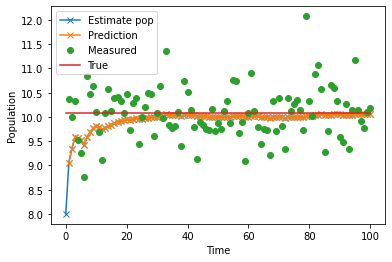

In [5]:
def Kalman_extrapolate_1D(x_predict):
    x_esti =  x_predict 
    return x_esti

def Kalman_covar_extrapolate_1D(px_predict):
    px_esti = px_predict
    return px_esti

def Kalman_gain_1D(px_esti, r_predict):
    return px_esti/(px_esti + r_predict)

def Kalman_update_1D(x_esti, z_predict, K):
    inno = z_predict - x_esti
    return x_esti + K * inno

def Kalman_covar_update_1D(px_esti, K):
    return px_esti * (1 - K)

def Kalman_1D(x_esti, px_esti, zarr, r0, do_print = False):
    #initialize
    x_esti_arr, px_esti_arr, x_predict_arr = [x_esti], [px_esti], []
    
    for index, z in enumerate(zarr):
        K = Kalman_gain_1D(px_esti, r0)
        x_predict = Kalman_update_1D(x_esti, z, K)
        px_predict = Kalman_covar_update_1D(px_esti, K)
        
        x_esti = Kalman_extrapolate_1D(x_predict)
        px_esti = Kalman_covar_extrapolate_1D(px_predict)

        x_esti_arr.append(x_esti)
        px_esti_arr.append(px_esti)
        x_predict_arr.append(x_predict)
        
        #### for debug
        #print(x_predict)
        #print(px_predict)
        #print(K)
    if do_print:
        time = np.linspace(0, len(zarr), endpoint = True, num=len(zarr)+1)
        fig_kalman, ax_kalman = plt.subplots()
        ax_kalman.plot(time, x_esti_arr,'-x', label = 'Estimate pop')
        ax_kalman.plot(time[1:], x_predict_arr,'-x', label = 'Prediction')
        ax_kalman.plot(time[1:], zarr, 'o', label = 'Measured')
        ax_kalman.plot(time, np.ones(len(zarr)+1)*np.mean(zarr), label = 'True')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Population')
    return x_esti_arr, px_esti_arr, x_predict_arr

zs = gen_data(x0=10., v0=0., count=100, noise= .5, accel=0)
x_esti_arr, px_esti_arr, x_predict_arr = Kalman_1D(x_esti = 8, 
                                                   px_esti = 4, 
                                                   zarr = zs, 
                                                   r0 = 5, 
                                                   do_print = True)


# Implement process noise

A process noise represents how confident you are with the process model. In most literature, the process noise is represented by the matrix $\mathcal{Q}$. This quantity has generally been derived and well studied for sytem where its fundamental matrix follows Newtonian Kinetics, so we will not dive too deep into the derivation of process noise. The process nosie is added to the predicted variance during the process prediction.  

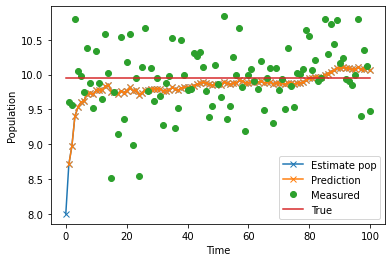

In [6]:
def Kalman_covar_extrapolate_1D(px_predict, process_noise):
    px_esti = px_predict + process_noise
    return px_esti

def Kalman_1D(x_esti, px_esti, zarr, r0, process_noise, do_print = False):
    #initialize
    x_esti_arr, px_esti_arr, x_predict_arr = [x_esti], [px_esti], []

    for index, z in enumerate(zarr):
        K = Kalman_gain_1D(px_esti, r0)
        x_predict = Kalman_update_1D(x_esti, z, K)
        px_predict = Kalman_covar_update_1D(px_esti, K)
        
        x_esti = Kalman_extrapolate_1D(x_predict)
        px_esti = Kalman_covar_extrapolate_1D(px_predict, process_noise)

        x_esti_arr.append(x_esti)
        px_esti_arr.append(px_esti)
        x_predict_arr.append(x_predict)
        
        #### for debug
        #print(x_predict)
        #print(px_predict)
        #print(K)
    if do_print:
        time = np.linspace(0, len(zarr), endpoint = True, num=len(zarr)+1)
        fig_kalman, ax_kalman = plt.subplots()
        ax_kalman.plot(time, x_esti_arr,'-x', label = 'Estimate pop')
        ax_kalman.plot(time[1:], x_predict_arr,'-x', label = 'Prediction')
        ax_kalman.plot(time[1:], zarr, 'o', label = 'Measured')
        ax_kalman.plot(time, np.ones(len(zarr)+1)*np.mean(zarr), label = 'True')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Population')
    return x_esti_arr, px_esti_arr, x_predict_arr

zs = gen_data(x0=10., v0=0., count=100, noise= .5, accel=0)
x_esti_arr, px_esti_arr, x_predict_arr = Kalman_1D(x_esti = 8, 
                                                   px_esti = 4, 
                                                   zarr = zs, 
                                                   r0 = 5, 
                                                   process_noise = 0.01,
                                                   do_print = True)